In [1]:
# try to numerically see the beta dynamics
# y = x @ W
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
n_embd = 32
vocab_size = 128
betas = torch.linspace(0, 1.0, steps=100)
batch_size = 1024
num_samples = 10 # sample W
temperatures = torch.logspace(-2, -1.2, steps=8)
dbeta = torch.zeros(8, 100)
dbeta1 = torch.zeros(8, 100)
loss = torch.zeros(8, 100)

In [3]:
for t_idx, temperature in enumerate(temperatures):
    for b_idx in range(100):
        for _ in range(num_samples):
            W = torch.randn(n_embd, vocab_size) / temperature / n_embd ** 0.5  # (n_embd, vocab_size)
            x = torch.randn(batch_size, n_embd)  # (B, n_embd)
            logits = x @ W  # (B, vocab_size)
            probs = F.softmax(logits, dim=-1)  # (B, vocab_size)
            probs_b = F.softmax(logits * betas[b_idx], dim=-1)  # (B, vocab_size)
            log_probs_b = F.log_softmax(logits * betas[b_idx], dim=-1)  # (B, vocab_size)
            loss[t_idx, b_idx] += F.kl_div(log_probs_b, probs, reduction='batchmean') / num_samples
            dbeta1[t_idx, b_idx] += - (probs_b * logits).sum() / batch_size
            dbeta[t_idx, b_idx] += - (probs_b * logits).sum() / batch_size + (probs * logits).sum() / batch_size
        dbeta[t_idx, b_idx] /= num_samples
        dbeta1[t_idx, b_idx] /= num_samples

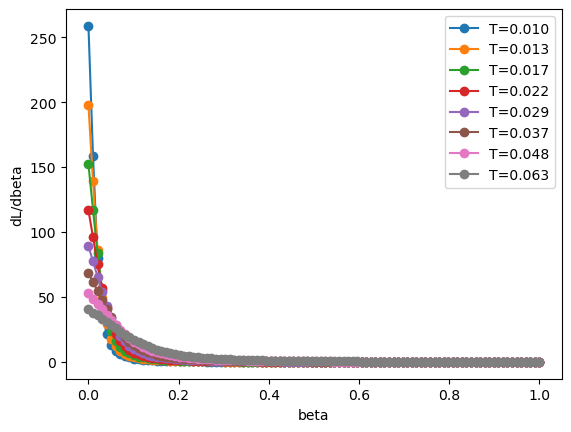

In [4]:
for t_idx, temperature in enumerate(temperatures):
    plt.plot(betas.numpy(), dbeta[t_idx].numpy(), 'o-',label=f'T={temperature.item():.3f}')
plt.xlabel('beta')
plt.ylabel('dL/dbeta')
plt.legend()

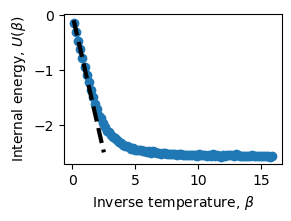

In [5]:
plt.figure(figsize=(2.8, 2.1), constrained_layout=True)
for temperature in [temperatures[-1]]:
    plt.plot(betas.numpy()[1:] / temperature.item(), dbeta1[-1,1:].numpy() * temperature.item(), 'o')
plt.plot([0.1, 2.5], [-0.1, -2.5], 'k--', linewidth=3)
plt.xlabel(r'Inverse temperature, $\beta$')
plt.ylabel(r'Internal energy, $U(\beta)$')
plt.savefig('../figures/Uversbeta.png',dpi = 300)

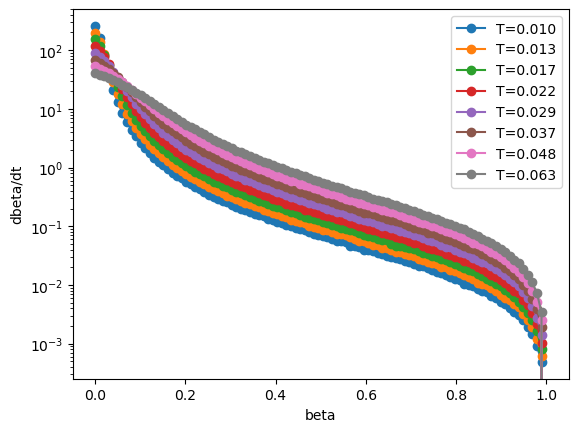

In [6]:
for t_idx, temperature in enumerate(temperatures):
    plt.plot(betas.numpy(), dbeta[t_idx].numpy(), 'o-',label=f'T={temperature.item():.3f}')
plt.xlabel('beta')
plt.ylabel('dbeta/dt')
plt.legend()
plt.yscale('log')
#plt.xscale('log')

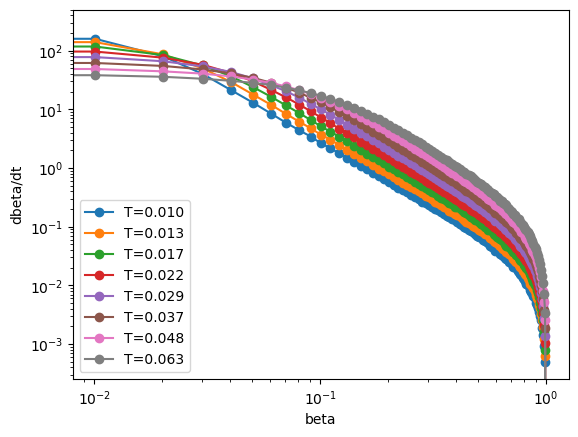

In [7]:
for t_idx, temperature in enumerate(temperatures):
    plt.plot(betas.numpy(), dbeta[t_idx].numpy(), 'o-',label=f'T={temperature.item():.3f}')
plt.xlabel('beta')
plt.ylabel('dbeta/dt')
plt.legend()
plt.yscale('log')
plt.xscale('log')

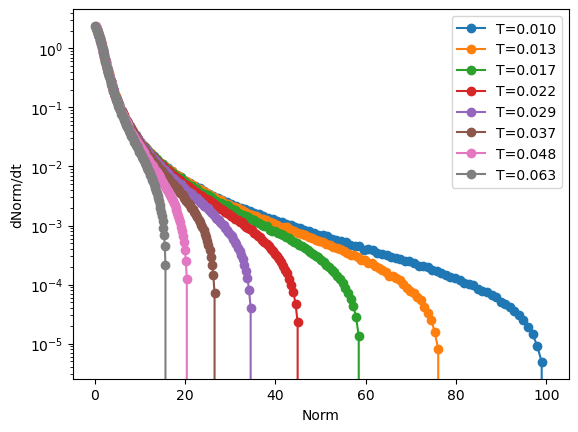

In [8]:
for t_idx, temperature in enumerate(temperatures):
    plt.plot(betas.numpy()[1:] / temperature.item(), dbeta[t_idx,1:].numpy() * temperature.item(), 'o-',label=f'T={temperature.item():.3f}')
plt.xlabel('Norm')
plt.ylabel('dNorm/dt')
plt.legend()
plt.yscale('log')
#plt.xscale('log')

In [9]:
# do a linear fitting
import numpy as np
fitout = np.polyfit(np.log(betas.numpy()[2:60] / temperatures[0].item()), np.log(dbeta[0,2:60].numpy() * temperatures[0].item()), 1, cov = True)
slope, intercept = fitout[0]
slope_std = np.sqrt(fitout[1][0,0])

In [10]:
slope, intercept, slope_std

(-2.261467775378434, 1.6029510081339624, 0.010426735203585627)

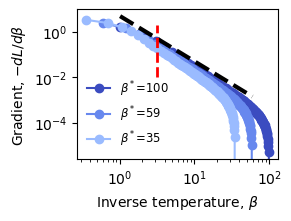

In [22]:
cmap = plt.get_cmap('coolwarm')
plt.figure(figsize=(2.8,2.1), constrained_layout=True)
for t_idx, temperature in enumerate(temperatures[[0,2,4]]):
    plt.plot(betas.numpy()[1:] / temperature.item(), dbeta[t_idx,1:].numpy() * temperature.item(), 'o-',label=rf'$\beta^*$={1/temperature.item():.0f}', 
                color = cmap(t_idx / 7))
plt.plot(betas.numpy()[1:60] / temperatures[0].item(), np.exp(intercept) * (betas.numpy()[1:60] / temperatures[0].item())**(-2), 'k--', linewidth=3)
c0 = np.sqrt(2 * np.log(128))  # from the theory
plt.plot([c0, c0], [1e-2, 2e0], 'r--', linewidth=2)
plt.xlabel(r'Inverse temperature, $\beta$')
plt.ylabel(r'Gradient, $- dL / d \beta$')
plt.legend(frameon=False, fontsize = 'small')
plt.yscale('log')
plt.xscale('log')
plt.savefig('../figures/energydiff.pdf')

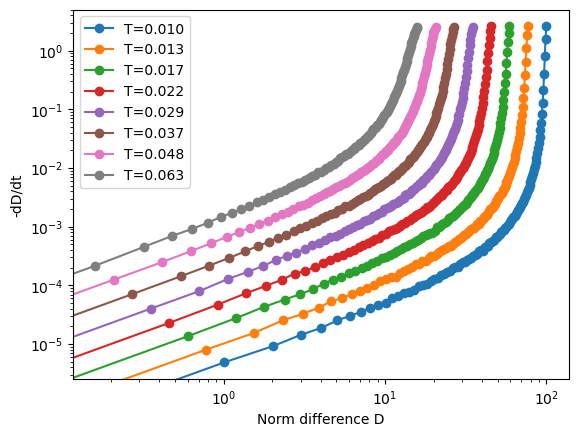

In [12]:
for t_idx, temperature in enumerate(temperatures):
    plt.plot((1 - betas.numpy()) / temperature.item(), dbeta[t_idx].numpy() * temperature.item(), 'o-',label=f'T={temperature.item():.3f}')
plt.xlabel('Norm difference D')
plt.ylabel('-dD/dt')
plt.legend()
plt.yscale('log')
plt.xscale('log')

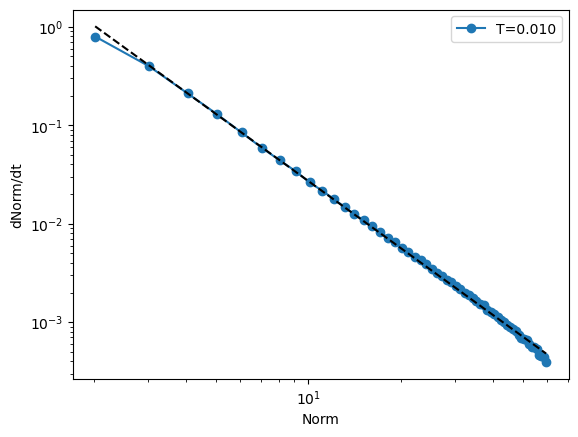

In [13]:
for t_idx, temperature in enumerate(temperatures):
    plt.plot(betas.numpy()[2:60] / temperature.item(), dbeta[t_idx,2:60].numpy() * temperature.item(), 'o-',label=f'T={temperature.item():.3f}')
    plt.plot(betas.numpy()[2:60] / temperature.item(), np.exp(intercept) * (betas.numpy()[2:60] / temperature.item())**slope, 'k--')
    if t_idx >= 0:
        break
plt.xlabel('Norm')
plt.ylabel('dNorm/dt')
plt.legend()
plt.yscale('log')
plt.xscale('log')

In [14]:
fitout = np.polyfit(np.log(betas.numpy()[1:10] / temperatures[0].item()), np.log(loss[0,1:10].numpy()), 1, cov = True)
slopeL, interceptL = fitout[0]
slopeL_std = np.sqrt(fitout[1][0,0])
print(slopeL, interceptL, slopeL_std)

-1.1506173348316375 1.146046912493256 0.040581397998344135


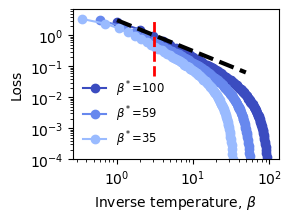

In [21]:
cmap = plt.get_cmap('coolwarm')
plt.figure(figsize=(2.8,2.1), constrained_layout=True)
for t_idx, temperature in enumerate(temperatures[[0,2,4]]):
    plt.plot(betas[1:].numpy() / temperature.item(), loss[t_idx,1:].numpy(), 'o-',label=rf'$\beta^*$={1/temperature.item():.0f}',
                color = cmap(t_idx / 7))
plt.plot(betas[1:50].numpy() / temperatures[0].item(), np.exp(interceptL) * (betas[1:50].numpy() / temperatures[0].item())**(-1), 'k--', linewidth=3)
c0 = np.sqrt(2 * np.log(128))  # from the theory
plt.plot([c0, c0], [5e-2, 3e0], 'r--', linewidth=2)
plt.ylabel('Loss')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-4, 7)
plt.legend(frameon=False, fontsize = 'small')
plt.xlabel(r'Inverse temperature, $\beta$')
plt.savefig('../figures/lossbeta.pdf')

(1e-05, 11.675719215668362)

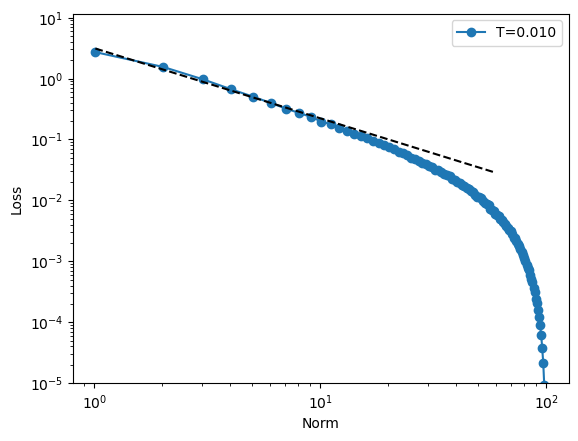

In [16]:
for t_idx, temperature in enumerate(temperatures):
    plt.plot(betas[1:].numpy() / temperature.item(), loss[t_idx,1:].numpy(), 'o-',label=f'T={temperature.item():.3f}')
    plt.plot(betas[1:60].numpy() / temperature.item(), np.exp(interceptL) * (betas[1:60].numpy() / temperature.item())**slopeL, 'k--')
    if t_idx >= 0:
        break
plt.xlabel('Norm')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-5, None)

In [17]:
1.14/3.26

0.3496932515337423